# Dogs vs Cats

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
! pip install livelossplot

In [1]:
# import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random

# to make this notebook's output stable across runs
np.random.seed(2210)


### Add the custom framework

In [2]:
WORK_DIR = '/kaggle/working'
INPUT_DIR = '/kaggle/input/dogs-vs-cats'
DATA_DIR = os.path.join(WORK_DIR, 'data')

if not os.path.isdir(DATA_DIR):
    os.mkdir(DATA_DIR)

if not os.path.isdir(CKPT_DIR):
    os.mkdir(CKPT_DIR)

import sys
sys.path.append('/kaggle/input/mlframework')
# sys.path.append('/home/jovyan/ml_framework')
# sys.path.append(os.path.join(os.path.expanduser('~'), 'github', 'ml_framework'))

from utils import file_utils, charts
_ = charts.set_rc(titlesize=10)

<Figure size 432x288 with 0 Axes>

In [3]:
# ! ls /kaggle/input/dogs-vs-cats
! ls /kaggle/working

__notebook_source__.ipynb  data  weights


In [4]:
# unzip the zip files
file_utils.unzip_file(os.path.join(INPUT_DIR,'train.zip'), os.path.join(WORK_DIR, 'data'))
file_utils.unzip_file(os.path.join(INPUT_DIR,'test1.zip'), os.path.join(WORK_DIR, 'data'))

/kaggle/input/dogs-vs-cats/train.zip extracted to directory : /kaggle/working/data
/kaggle/input/dogs-vs-cats/test1.zip extracted to directory : /kaggle/working/data


### Load the csv file 

In [5]:
TRAIN_DIR = os.path.join(DATA_DIR,'train')
TEST_DIR = os.path.join(DATA_DIR,'test1')
# Load the submission dataframe
submission_df = pd.read_csv(os.path.join(INPUT_DIR,'sampleSubmission.csv'))
submission_df.head()

,id,label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [6]:
train_files = os.listdir(TRAIN_DIR)
test_files = os.listdir(TEST_DIR)

print(f"Total no. of training images : {len(train_files)}")
print(f"Total no. of test images : {len(test_files)}")

data = dict()
data['image'] = train_files
data['category'] = [ f'{x[0]}' for x in [x.split('.') for x in train_files] ]
# len(data['image']), len(data['category'])

df = pd.DataFrame(data)
df.head()

Total no. of training images : 25000
Total no. of test images : 12500


,image,category
0,dog.5008.jpg,dog
1,dog.8977.jpg,dog
2,dog.9029.jpg,dog
3,cat.9879.jpg,cat
4,cat.6395.jpg,cat


# Explore the data

In [7]:
charts.plot_images([os.path.join(TRAIN_DIR, i) for i in random.sample(train_files, 9)], 3, 3)

AssertionError: Number of subplots lesser than the list

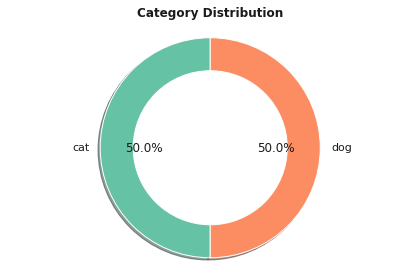

In [8]:
charts.donut(df['category'], title='Category Distribution', figsize=(6,4), titlesize=12)

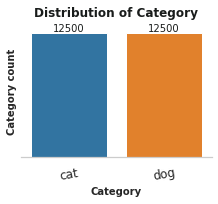

In [9]:
charts.value_count_bar(df['category'], normalize=False, figsize=(3.2, 3), titlesize=12, labelsize=10)

In [10]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size=0.1, shuffle=True)

train_df.head()

,image,category
9878,cat.11228.jpg,cat
16985,dog.10524.jpg,dog
3734,dog.10283.jpg,dog
1571,dog.437.jpg,dog
11993,dog.8117.jpg,dog


### Build the model from scratch

In [ ]:
from tensorflow.keras.layers import Conv2D, Dropout, Dense, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from cnn.model_builder import get_vgg_block
from livelossplot.inputs.keras import PlotLossesCallback

# Build the model
# model = get_vgg_block(num_blocks=4, input_shape=(150,150,3))
# model.add(Dense(516, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
# model.summary()
# model.compile(Adam(), loss='binary_crossentropy', metrics=["accuracy"])

In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0 / 255, horizontal_flip=True, vertical_flip=True)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=TRAIN_DIR,
    x_col="image",
    y_col="category",
    batch_size=64,
    class_mode="binary",
    target_size=(150, 150),
)

valid_datagen = ImageDataGenerator(rescale=1.0 / 255)

valid_generator = valid_datagen.flow_from_dataframe(
    valid_df,
    directory=TRAIN_DIR,
    x_col="image",
    y_col="category",
    batch_size=64,
    class_mode="binary",
    target_size=(150, 150),
)

earlystopping = EarlyStopping(monitor="val_loss", 
                              patience=4)

weight_filepath = 'vgg_block_weight_best.hdf'
checkpoint= ModelCheckpoint(
    filepath=weight_filepath,
    save_weights_only=True,
    monitor="val_loss",
    mode="max",
    save_best_only=True,
)

In [ ]:
# Train and fit model
history = model.fit(
    train_generator, validation_data=valid_generator,
    callbacks = [earlystopping, checkpoint],
    epochs=50, verbose=1
)

model.save_weights('model_weight.h5')
result_df = pd.DataFrame(history.history)
result_df.head()

In [ ]:
charts.plot_loss_acc(history)

### Build the model from VGG

In [27]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dropout, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
from livelossplot.inputs.keras import PlotLossesCallback

vgg_model = VGG19(include_top=False, 
                  input_shape=(224,224,3), 
                  weights='imagenet', 
                  pooling='avg')

# train  last 2 layes of VGG as well
for layer in vgg_model.layers[:-4]:
    layer.trainable = False

x = Flatten()(vgg_model.output)
x = Dense(1024, activation='relu', kernel_initializer='he_uniform')(x)
x = Dense(512, activation='relu', kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)


model = Model(inputs=vgg_model.input, outputs=x)
model.summary()
model.compile(Adam(), loss='binary_crossentropy', metrics=["accuracy"])

In [31]:
train_datagen = ImageDataGenerator(rescale=1.0 / 255, horizontal_flip=True, vertical_flip=True)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=TRAIN_DIR,
    x_col="image",
    y_col="category",
    batch_size=64,
    class_mode="binary",
    target_size=(150, 150),
    preprocessing_function=preprocess_input
)

valid_datagen = ImageDataGenerator(rescale=1.0 / 255)

valid_generator = valid_datagen.flow_from_dataframe(
    valid_df,
    directory=TRAIN_DIR,
    x_col="image",
    y_col="category",
    batch_size=64,
    class_mode="binary",
    target_size=(150, 150),
    preprocessing_function=preprocess_input
)

# define callbacks
earlystopping = EarlyStopping(monitor="val_loss", 
                              patience=5)

weight_filepath = 'vgg_model_weights_best_unfreezelast4.hdf5'
checkpoint= ModelCheckpoint(
    filepath=weight_filepath,
    save_weights_only=True,
    monitor="val_loss",
    mode="max",
    save_best_only=True,
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

plot_loss = PlotLossesCallback()

Found 22500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


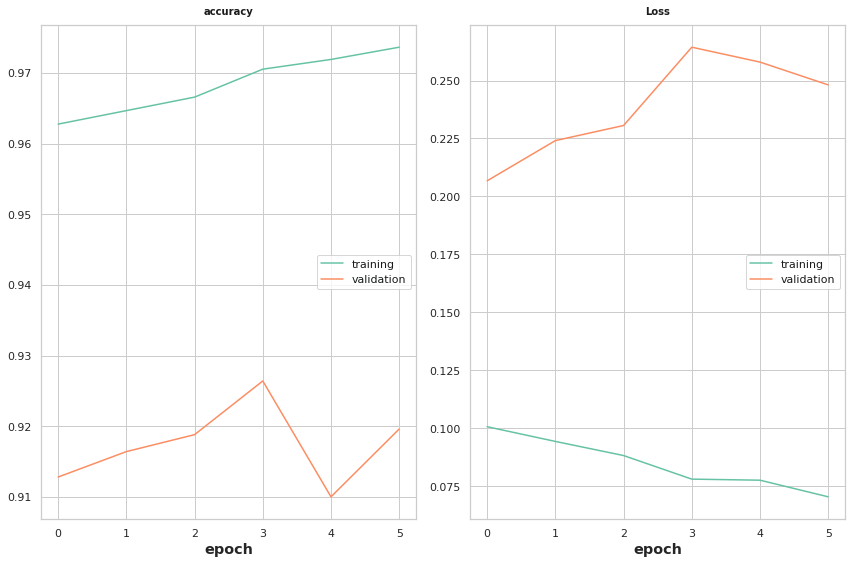

accuracy
	training         	 (min:    0.963, max:    0.974, cur:    0.974)
	validation       	 (min:    0.910, max:    0.926, cur:    0.920)
Loss
	training         	 (min:    0.070, max:    0.101, cur:    0.070)
	validation       	 (min:    0.207, max:    0.264, cur:    0.248)


,loss,accuracy,val_loss,val_accuracy,lr
0,0.100669,0.962756,0.206755,0.9128,0.001
1,0.094327,0.964667,0.224096,0.9164,0.001
2,0.088233,0.966578,0.230602,0.9188,0.001
3,0.078060,0.970533,0.264384,0.9264,0.001
4,0.077601,0.971911,0.257961,0.9100,0.001


In [32]:
# Train and fit model
history = model.fit(
    train_generator, validation_data=valid_generator,
    callbacks = [earlystopping, checkpoint, plot_loss, reduce_lr],
    epochs=50, verbose=1
)

# model.save_weights('vgg_model_weight.h5')
result_df = pd.DataFrame(history.history)
result_df.head()

In [35]:
test_df = pd.DataFrame({'image': test_files})

test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=TEST_DIR,
    x_col="image",
    y_col=None,
    batch_size=64,
    class_mode=None,
    target_size=(150, 150),
    preprocessing_function=preprocess_input # for VGG model only
)

test_df.head()

Found 12500 validated image filenames.


,image
0,7725.jpg
1,4405.jpg
2,7500.jpg
3,10618.jpg
4,2316.jpg


In [36]:
model.load_weights(weight_filepath)
predictions = model.predict(test_generator, steps=np.ceil(len(test_files)/64))
test_df['prediction'] = predictions
test_df['label'] = test_df['prediction'].apply(lambda x : 1 if x > 0.5 else 0)
test_df['id'] = test_df['image'].apply(lambda x : int(x.split('.')[0]))
test_df

,image,prediction,label,id
0,7725.jpg,2.357264e-03,0,7725
1,4405.jpg,2.057139e-04,0,4405
2,7500.jpg,2.207643e-07,0,7500
3,10618.jpg,9.981287e-01,1,10618
4,2316.jpg,9.986714e-01,1,2316
...,...,...,...,...
12495,306.jpg,9.998715e-01,1,306
12496,10984.jpg,2.691172e-02,0,10984
12497,1110.jpg,4.936142e-06,0,1110
12498,12263.jpg,8.002356e-09,0,12263


In [37]:
test_df[test_df['id'].isin([18, 19, 1235, 4756])]

,image,prediction,label,id
2566,18.jpg,3.993123e-06,0,18
5676,4756.jpg,1.160125e-05,0,4756
8427,1235.jpg,2.365126e-13,0,1235
10577,19.jpg,4.467737e-05,0,19


In [38]:
submission_df = test_df[['id','label']]
submission_df = submission_df.sort_values(by=['id'], ignore_index=True)
submission_df

,id,label
0,1,1
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
12495,12496,1
12496,12497,1
12497,12498,0
12498,12499,1


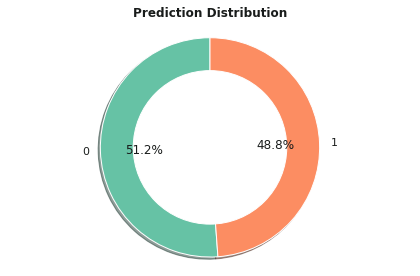

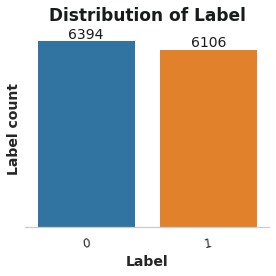

In [40]:
charts.donut(submission_df['label'], title='Prediction Distribution', figsize=(6,4), titlesize=12)
charts.value_count_bar(submission_df['label'], normalize=False, figsize=(4,4))

In [41]:
submission_df.to_csv('submission.csv', index=False)